# Breast Cancer Detection Prototype Model

In [1]:
import numpy as np
import keras
from tensorflow.keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

2025-07-23 13:46:13.457995: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-23 13:46:13.505849: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-23 13:46:13.702422: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-23 13:46:13.818545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753296373.959098     374 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753296374.00

For this prototype, I will be making a few changes to the model from the feasibility notebook. First, I'd want to make note of the class imbalance in the training set according to the Kaggle page:

- 0: 1,569 images 
- 1: 803 images

So from now on I'll be adding a class_weight parameter to the model training to prioritize the minority class and prevent the majority class from skewing the results. I'm also changing the metrics for evaluating the model, I'll be prioritizing recall instead of accuracy because a false negative on a mammogram can have potentially deadly consequences and accuracy can give a bas to the majority class. Additionally, I'll also be using a confusion matrix to get a visual representation of the model's performance. 

First, let's load the data and take a look at the images.

In [2]:
# Converting the images sizes down to 224x224 from the original 640x640 and setting a smaller batch size 
# since my laptop is kind of slow.
image_size = (224, 224)
batch_size = 10

# Load in the training set
train_ds = keras.utils.image_dataset_from_directory(
    "train",
    image_size=image_size,
    batch_size=batch_size,
    label_mode = "binary"
)

# Load in the validation set
valid_ds = keras.utils.image_dataset_from_directory(
    "valid",
    image_size=image_size,
    batch_size=batch_size,
    label_mode = "binary"
)

Found 2372 files belonging to 2 classes.
Found 675 files belonging to 2 classes.


2025-07-23 13:46:42.451872: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


/tmp/ipykernel_374/193507620.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(labels[i].numpy())
2025-07-23 13:47:14.309158: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


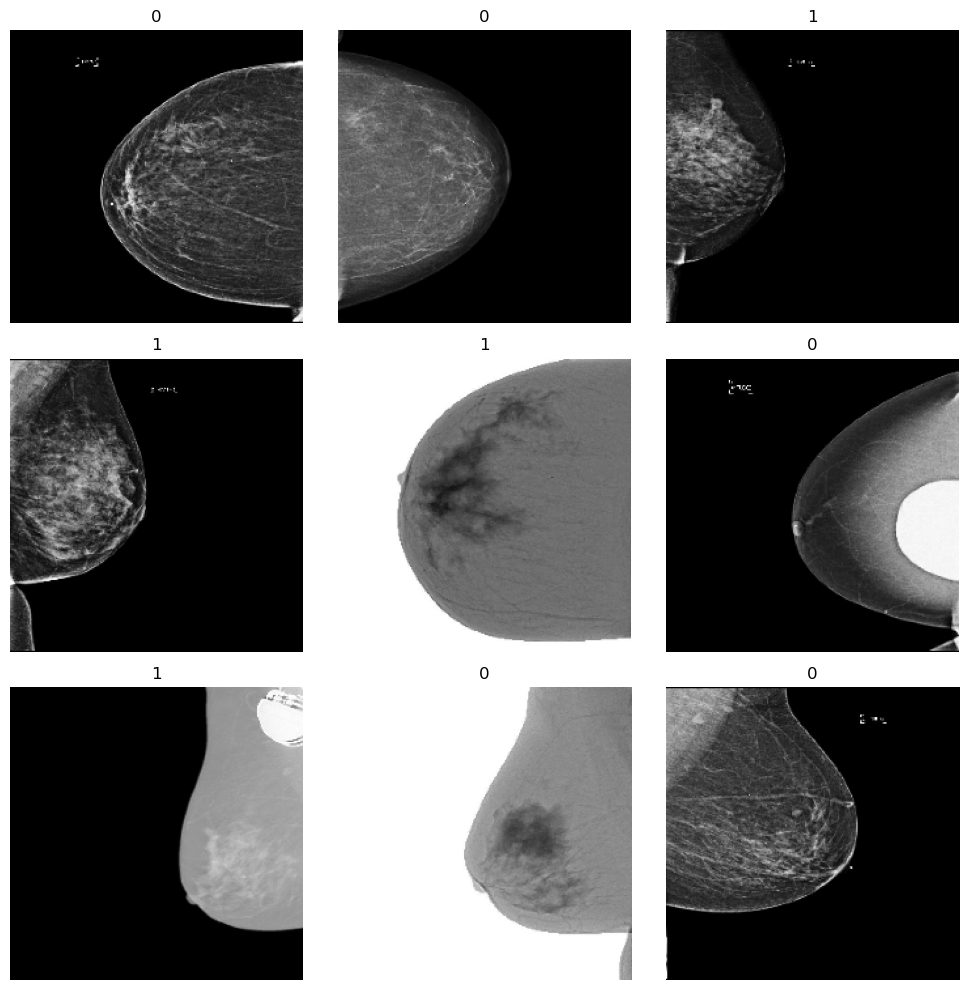

In [4]:
# Get class labels
class_names = train_ds.class_names

# Show a batch of training images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = int(labels[i].numpy())
        plt.title(class_names[label])
        plt.axis("off")
        
plt.tight_layout()
plt.show()

For this project, I'll be using a pre-trained model to classify these images as opposed to training a model from scratch. The only change I'll make in creating the transfer model is using the sigmoid function since this is a binary classification problem.

In [5]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
valid_ds = valid_ds.prefetch(tf_data.AUTOTUNE)

In [6]:
# Function that will create a one of the pre-trained models that Keras offers

def make_transfer_model(input_shape, num_classes):
    
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    
    backbone.trainable = False

    inputs = layers.Input(input_shape)
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
        activation = "sigmoid"
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)

    outputs = layers.Dense(units, activation=activation)(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

In [7]:
model2 = make_transfer_model(input_shape=image_size + (3,), num_classes=2)

Now, I'll add the class_weight parameter and run the training.

In [9]:
# Get the labels
train_labels = np.concatenate([label.numpy() for _, label in train_ds.unbatch()])

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels)

# Convert to dictionary format 
class_weight_dict = {int(k): float(v) for k, v in zip(np.unique(train_labels), class_weights)}

# Set the parameters and run the training
epochs = 8
optimizer = optimizers.Adam(learning_rate=0.001)
callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),]

model2.compile(optimizer=optimizer,loss="binary_crossentropy",metrics=[keras.metrics.Recall(name="recall")],)

history = model2.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=valid_ds,
    class_weight=class_weight_dict,)

Epoch 1/8


2025-07-23 14:10:37.861408: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


238/238 ━━━━━━━━━━━━━━━━━━━━ 81s 316ms/step - loss: 0.7693 - recall: 0.5509 - val_loss: 0.8523 - val_recall: 0.9515
Epoch 2/8
238/238 ━━━━━━━━━━━━━━━━━━━━ 58s 242ms/step - loss: 0.7093 - recall: 0.6307 - val_loss: 0.8336 - val_recall: 0.9427
Epoch 3/8
238/238 ━━━━━━━━━━━━━━━━━━━━ 59s 247ms/step - loss: 0.6529 - recall: 0.6494 - val_loss: 0.7270 - val_recall: 0.8106
Epoch 4/8
238/238 ━━━━━━━━━━━━━━━━━━━━ 55s 232ms/step - loss: 0.6590 - recall: 0.6446 - val_loss: 0.7838 - val_recall: 0.8634
Epoch 5/8
238/238 ━━━━━━━━━━━━━━━━━━━━ 62s 259ms/step - loss: 0.6546 - recall: 0.6523 - val_loss: 0.9040 - val_recall: 0.9471
Epoch 6/8
238/238 ━━━━━━━━━━━━━━━━━━━━ 56s 237ms/step - loss: 0.6398 - recall: 0.6872 - val_loss: 0.9480 - val_recall: 0.9604
Epoch 7/8
238/238 ━━━━━━━━━━━━━━━━━━━━ 111s 467ms/step - loss: 0.6224 - recall: 0.7145 - val_loss: 0.7198 - val_recall: 0.7621
Epoch 8/8
238/238 ━━━━━━━━━━━━━━━━━━━━ 62s 259ms/step - loss: 0.6094 - recall: 0.6632 - val_loss: 0.8671 - val_recall: 0.9119


Let's define some evaluation functions and run them. 

In [36]:
# Function that displayings a training vs validaton metric

def plot_recall(history):
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    
    ax[0].plot(history.history["recall"], label="Training Recall")
    ax[0].plot(history.history["val_recall"], label="Validation Recall")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Recall")
    ax[0].set_title("Training vs Validation Recall")
    ax[0].legend()
    
    ax[1].plot(history.history["loss"], label="Training Loss")
    ax[1].plot(history.history["val_loss"], label="Validation Loss")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].set_title("Training vs Validation Loss")
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

# Function that creates and displays a confusion matrix
def confusion(ds):
    y_true = []
    y_pred = []

    for images, labels in ds:
        preds = model2.predict(images)
        preds = (preds > 0.5).astype("int32")  # threshold at 0.5 for binary
        y_true.extend(labels.numpy())
        y_pred.extend(preds.flatten())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

Very interesting results. The validation recall is significantly higher than training recall and the 0 class is correctly classified at a much higher rate than the majority 1 class. I'll have to take some time to investigate these results and see if I did anything wrong during training. 

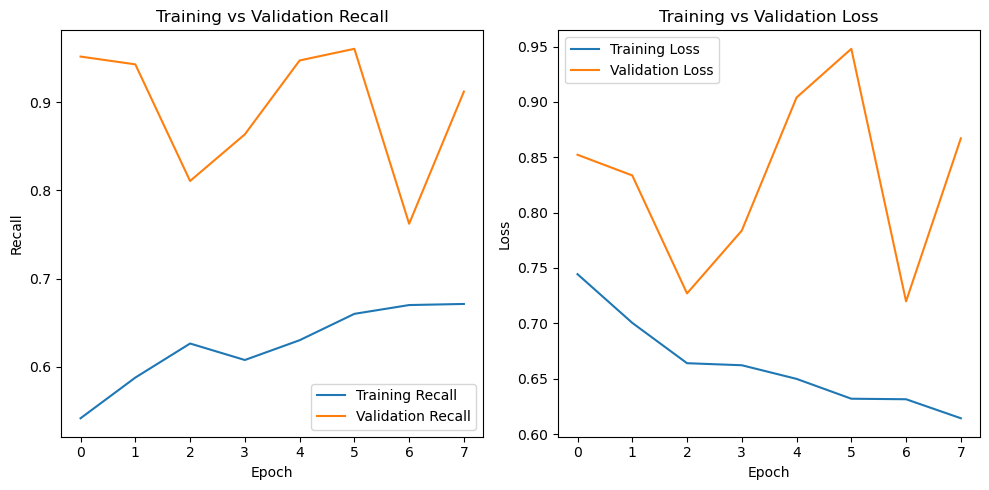

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ -1s -1234938us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━

2025-07-23 14:46:18.557386: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


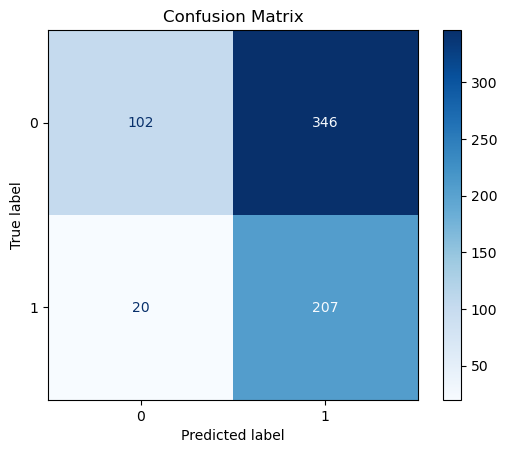

In [40]:
plot_recall(history)
confusion(valid_ds)